In [1]:
%matplotlib notebook
from functools import partial as _partial

import numpy as np
import scipy.optimize as scyopt
import scipy.stats as scystat
from sklearn.datasets import make_regression as _create_data
# import gpy
import matplotlib.pyplot as mplt
import ipywidgets

import gp_lib as lib

mplt.rcParams.update({
    'font.size':10, 'axes.grid': True, 'grid.alpha': 0.5,
    'grid.linestyle': '--', 'grid.linewidth': 1, 'lines.linewidth': 2})

# Multivariate Gaussian

$\newcommand{\vect}[1]{{\mathbf{\boldsymbol{{#1}}}}}$
The multivariate gaussian is the extension of the gaussian distribution to higher dimensions. It can be used to model the joint probability distribution of $N$ random variables $y_i$, which may be thought of as a vector in $\vect{y}\in \mathbb{R}^N$, : 

$$\vect{y} \sim \mathcal{N}(\vect{\mu}, \vect{\Sigma}) = \frac{1}{\sqrt{(2\pi)^N|\vect{\Sigma}|}}\exp\left(-\frac12(\vect{y}-\vect{\mu})^T\vect{\Sigma}^{-1}(\vect{y}-\vect{\mu})\right)$$

This distribution is completely characterized by the vector mean $\vect{\mu}\in\mathbb{R}^N$ and the covariance matrix $\vect{\Sigma}\in\mathbb{R}^N\times\mathbb{R}^N$.

<IPython.core.display.Javascript object>


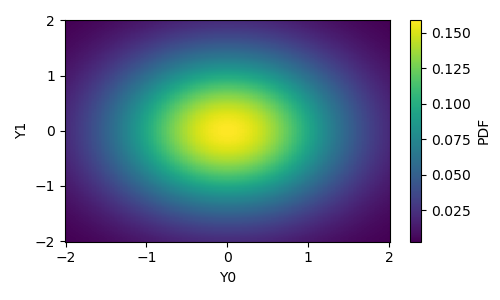

interactive(children=(FloatSlider(value=0.0, description='correlation', max=0.99, min=-0.99, step=0.01), Outpu…

In [3]:
fig, ax = mplt.subplots(1, 1, figsize=(5, 3))
ax.set_ylabel('Y1')
ax.set_xlabel('Y0')
ax.grid(False)

# Define the grid of x and y values
y1 = np.linspace(-2, 2, 200)
y1, y2 = np.meshgrid(y1, y1)
pos = np.empty(y1.shape + (2,))
pos[:, :, 0] = y1
pos[:, :, 1] = y2

mean = np.array([0.0, 0.0])
pos -= mean

surf = ax.pcolormesh(y1, y2, y2)
fig.colorbar(surf, label='PDF')

@ipywidgets.interact
def plot_gauss(correlation=(-0.99, 0.99, 0.01)):
    # Code done by chatgpt with a few modifications

    # Define the covariance of the distribution
    cov = np.eye(2)
    cov[0, 1] = correlation
    cov[1, 0] = correlation

    # Calculate the inverse of the covariance matrix
    covi = np.linalg.inv(cov)

    # Calculate the multivariate Gaussian distribution
    
    z = np.exp(-1/2 * np.sum(pos @ covi * pos, axis=-1))
    z *= 1/np.sqrt((2*np.pi)**2 * np.linalg.det(cov))

    surf.set_array(z)
    surf.set_clim([z.min(), z.max()])
    fig.tight_layout()

## Gaussian distributions are closed under important operations:

### Marginalization:

Marginalization is the process of integrating out some variables of the gaussian distribution and only looking at some of them. 

Consider the join distribution of variables $\vect{x}$ and $\vect{y}$:

$$\begin{pmatrix}\vect{x} \\ \vect{y}\end{pmatrix} \sim
\mathcal{N}\left(
    \begin{pmatrix}\vect{\mu_x} \\ \vect{\mu_y}\end{pmatrix},
    \begin{pmatrix}\vect{\Sigma_{xx}} & \vect{\Sigma_{xy}}\\ \vect{\Sigma_{xy}}^T & \vect{\Sigma_{yy}}\end{pmatrix}\right) $$

If we are interested only on variable $\vect{x}$ we can integrate out variable $\vect{y}$:

$$\vect{x} \sim \int\,\mathrm{d}\vect{y}P(\vect{x},\vect{y}) = \mathcal{N}\left(\vect{\mu_x}, \vect{\Sigma_{xx}}\right)$$

where we notice that not only the result is gaussian, but that all the correlation terms between $\vect{x}$ and $\vect{y}$ does not appear on the final result. This means that we could have indefinetly many gaussian-distributed correlated variables, but if we are only interested in a few of them, we don't need to care to all the other correlation terms.

We can see this more clearly in the following 2D example, where we notice that varying the correlation does not change the dixtribution of $x$ on the right:

<IPython.core.display.Javascript object>


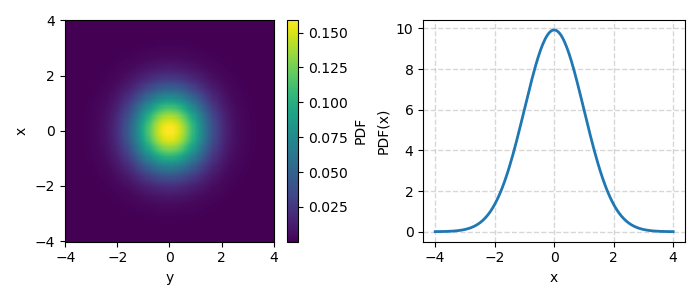

interactive(children=(FloatSlider(value=0.0, description='correlation', max=0.99, min=-0.99, step=0.01), Outpu…

In [4]:
fig, (ax, ay) = mplt.subplots(1, 2, figsize=(7, 3))
ax.set_ylabel('x')
ax.set_xlabel('y')
ax.grid(False)
ay.set_xlabel('x')
ay.set_ylabel('PDF(x)')

# Define the grid of x and y values
y = np.linspace(-4, 4, 200)
y1, y2 = np.meshgrid(y, y)
pos = np.empty(y1.shape + (2,))
pos[:, :, 0] = y1
pos[:, :, 1] = y2

mean = np.array([0.0, 0.0])
pos -= mean

surf = ax.pcolormesh(y1, y2, y2)
lin, = ay.plot(y, y)
fig.colorbar(surf, label='PDF')

@ipywidgets.interact
def plot_gauss(correlation=(-0.99, 0.99, 0.01)):
    # Code done by chatgpt with a few modifications

    # Define the covariance of the distribution
    cov = np.eye(2)
    cov[0, 1] = correlation
    cov[1, 0] = correlation

    # Calculate the inverse of the covariance matrix
    covi = np.linalg.inv(cov)

    # Calculate the multivariate Gaussian distribution
    
    pdf = np.exp(-1/2 * np.sum(pos @ covi * pos, axis=-1))
    pdf *= 1/np.sqrt((2*np.pi)**2 * np.linalg.det(cov))
    
    pdfx = np.trapz(pdf, axis=0)
    
    lin.set_data(y, pdfx)
    ay.relim()
    ay.autoscale_view()

    surf.set_array(pdf)
    surf.set_clim([pdf.min(), pdf.max()])
    fig.tight_layout()

### Conditioning:

Conditioning is the process of fixing a subset of the random variables and looking at the distribution of the other variables.

Consider the same setup defined above.

$$\begin{pmatrix}\vect{x} \\ \vect{y}\end{pmatrix} \sim
\mathcal{N}\left(
    \begin{pmatrix}\vect{\mu_x} \\ \vect{\mu_y}\end{pmatrix},
    \begin{pmatrix}\vect{\Sigma_{xx}} & \vect{\Sigma_{xy}}\\ \vect{\Sigma_{xy}}^T & \vect{\Sigma_{yy}}\end{pmatrix}\right) $$

The conditional probability of $\vect{x}$ when $\vect{y}$ is fixed is given by:

$$P(\vect{x}|\vect{y}=\vect{a}) = \mathcal{N}\left(\vect{\mu_x} + \vect{\Sigma_{xy}}\vect{\Sigma_{yy}}^{-1}(\vect{a}-\vect{\mu_y}),\,\, \vect{\Sigma_{xx}} - \vect{\Sigma_{xy}}\vect{\Sigma_{yy}}^{-1}\vect{\Sigma_{xy}}^T \right)$$

Note how in this case both, the mean and covariance, of the posterior on $\vect{x}$ are changed.

The example below show this fact for a 2D case:

<IPython.core.display.Javascript object>


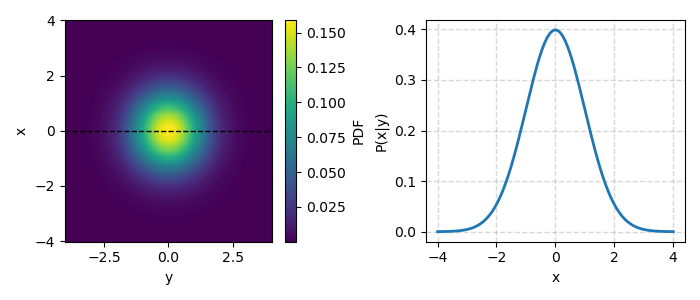

interactive(children=(FloatSlider(value=0.0, description='correlation', max=0.99, min=-0.99, step=0.01), Float…

In [5]:
fig, (ax, ay) = mplt.subplots(1, 2, figsize=(7, 3))
ax.set_ylabel('x')
ax.set_xlabel('y')
ax.grid(False)
ay.set_xlabel('x')
ay.set_ylabel('P(x|y)')

# Define the grid of x and y values
y = np.linspace(-4, 4, 200)
y1, y2 = np.meshgrid(y, y)
pos = np.empty(y1.shape + (2,))
pos[:, :, 0] = y1
pos[:, :, 1] = y2

mean = np.array([0.0, 0.0])
pos -= mean

surf = ax.pcolormesh(y1, y2, y2)
hlin = ax.axline((0, 0), (1, 0), lw=1, ls='--', color='k')
lin, = ay.plot(y, y)
fig.colorbar(surf, label='PDF')

@ipywidgets.interact
def plot_gauss(correlation=(-0.99, 0.99, 0.01), y0=(-4, 4, 0.01)):
    # Code done by chatgpt with a few modifications

    # Define the covariance of the distribution
    cov = np.eye(2)
    cov[0, 1] = correlation
    cov[1, 0] = correlation

    # Calculate the inverse of the covariance matrix
    covi = np.linalg.inv(cov)

    # Calculate the multivariate Gaussian distribution
    
    pdf = np.exp(-1/2 * np.sum(pos @ covi * pos, axis=-1))
    pdf *= 1/np.sqrt((2*np.pi)**2 * np.linalg.det(cov))
    
    sigx = cov[0, 0] - correlation**2/cov[1, 1]
    mux = 0 + correlation/cov[1, 1]*(y0-0)
    pdfx = np.exp(-1/2 * (y-mux)**2/sigx**2)
    pdfx /= np.sqrt(2 * np.pi * sigx**2)
    lin.set_data(y, pdfx)
    ay.relim()
    ay.autoscale_view()
    
    global hlin
    hlin.remove()
    hlin = ax.axline((0, y0), (1, y0), lw=1, ls='--', color='k')
    surf.set_array(pdf)
    surf.set_clim([pdf.min(), pdf.max()])
    fig.tight_layout()

### Affine Transformation

An affine transformation of a random variable $\vect{x}\in\mathbb{R}^N$ into another random variable $\vect{y}\in\mathbb{R}^M$ is defined by:

$$ \vect{y} = \vect{c} + \vect{B}\vect{x}$$

where $\vect{c} \in \mathbb{R}^M$ and $\vect{B}\in\mathbb{R}^M\times\mathbb{R}^N$ are constants.

Given that $\vect{x}$ is distributed normally, $\vect{x}\sim\mathcal{N}(\vect{\mu_x},\, \vect{\Sigma})$, then $\vect{y}$ will also be distributed normally:

$\vect{y}\sim\mathcal{N}(\vect{c} + \vect{B}\vect{\mu_x},\, \vect{B}\vect{\Sigma}\vect{B}^T)$


As an example, let's look to the 2D case below, where $\vect{B}=(a, b)$, with $a,b\in\mathbb{R}$:

<IPython.core.display.Javascript object>


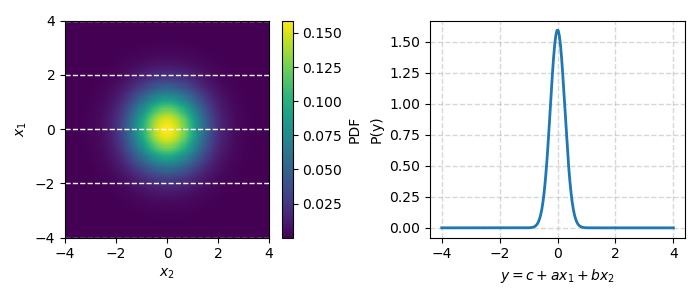

interactive(children=(FloatSlider(value=0.0, description='correlation', max=0.99, min=-0.99, step=0.01), Float…

In [6]:
fig, (ax, ay) = mplt.subplots(1, 2, figsize=(7, 3))
ax.set_ylabel('$x_1$')
ax.set_xlabel('$x_2$')
ax.grid(False)
ay.set_xlabel('$y = c + ax_1 + bx_2$')
ay.set_ylabel('P(y)')

# Define the grid of x and y values
y = np.linspace(-4, 4, 200)
y1, y2 = np.meshgrid(y, y)
pos = np.empty(y1.shape + (2,))
pos[:, :, 0] = y1
pos[:, :, 1] = y2

mean = np.array([0.0, 0.0])
pos -= mean

surf = ax.pcolormesh(y1, y2, y2)
hlins = [
    ax.axline((0, 0), slope=0, lw=1, ls='--', color='k')
    for yi in np.linspace(-8, 8, 17)]
lin, = ay.plot(y, y)
fig.colorbar(surf, label='PDF')

@ipywidgets.interact
def plot_gauss(
        correlation=(-0.99, 0.99, 0.01), a=(-10, 10, 0.01), b=(0.01, 1, 0.01),
        c=(-4, 4, 0.01)):
    # Code done by chatgpt with a few modifications

    # Define the covariance of the distribution
    cov = np.eye(2)
    cov[0, 1] = correlation
    cov[1, 0] = correlation

    # Calculate the inverse of the covariance matrix
    covi = np.linalg.inv(cov)

    # Calculate the multivariate Gaussian distribution
    
    pdf = np.exp(-1/2 * np.sum(pos @ covi * pos, axis=-1))
    pdf *= 1/np.sqrt((2*np.pi)**2 * np.linalg.det(cov))
    
    B = np.array([a, b])
    sigy = B @ cov @ B.T
    muy = c + B @ np.array([0, 0])
    pdfy = np.exp(-1/2 * (y-muy)**2/sigy**2)
    pdfy /= np.sqrt(2 * np.pi * sigy**2)
    lin.set_data(y, pdfy)
    ay.relim()
    ay.autoscale_view()
    
    global hlins
    _ = [h.remove() for h in hlins]
    hlins = [
        ax.axline((0, (yi-c)/b), slope=-a/b, lw=1, ls='--', color='w')
        for yi in np.linspace(-8, 8, 17)]
    surf.set_array(pdf)
    surf.set_clim([pdf.min(), pdf.max()])
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])
    fig.tight_layout()

### Product of two distributions

The multivariate gaussian is also closed under multiplication. 

Given two normal distributions

$$\mathcal{N}(\vect{\mu_1},\, \vect{\Sigma_1})\quad\mathcal{N}(\vect{\mu_2},\, \vect{\Sigma_2}),$$

the product between them is also a gaussian:

$$\mathcal{N}(\vect{\mu_3},\, \vect{\Sigma_3})=\mathcal{N}(\vect{\mu_1},\, \vect{\Sigma_1})\mathcal{N}(\vect{\mu_2},\, \vect{\Sigma_2}),$$

where

$$\vect{\Sigma_3} = \vect{\Sigma_1}\left(\vect{\Sigma_1} + \vect{\Sigma_2}\right)^{-1}\vect{\Sigma_2}$$
$$\vect{\mu_3} = 
\vect{\Sigma_2}\left(\vect{\Sigma_1} + \vect{\Sigma_2}\right)^{-1}\vect{\mu_1} + 
\vect{\Sigma_1}\left(\vect{\Sigma_1} + \vect{\Sigma_2}\right)^{-1}\vect{\mu_2}.$$

Let's again look at a 2D example:

<IPython.core.display.Javascript object>


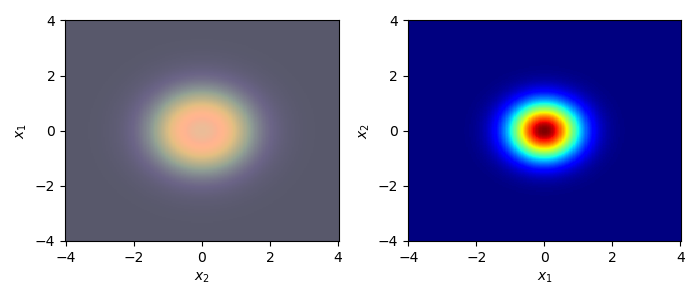

In [7]:
fig, (ax, ay) = mplt.subplots(1, 2, figsize=(7, 3))
ax.set_ylabel('$x_1$')
ax.set_xlabel('$x_2$')
ax.grid(False)
ay.set_xlabel('$x_1$')
ay.set_ylabel('$x_2$')
ay.grid(False)

# Define the grid of x and y values
y = np.linspace(-4, 4, 200)
y1, y2 = np.meshgrid(y, y)
pos = np.empty(y1.shape + (2,))
pos[:, :, 0] = y1
pos[:, :, 1] = y2

surf1 = ax.pcolormesh(y1, y2, y2, alpha=0.3, cmap='jet')
surf2 = ax.pcolormesh(y1, y2, y2, alpha=0.5, cmap='copper')
surf3 = ay.pcolormesh(y1, y2, y2, alpha=1, cmap='jet')

def plot_gauss(
        corr1=0, mu1_1=0, mu1_2=0,
        corr2=0, mu2_1=0, mu2_2=0,
        calculated=False):
    # Code done by chatgpt with a few modifications

    # Define the covariance of the distribution
    mu1 = np.array([mu1_1, mu1_2])
    cov1 = np.eye(2)
    cov1[0, 1] = corr1
    cov1[1, 0] = corr1

    mu2 = np.array([mu2_1, mu2_2])
    cov2 = np.eye(2)
    cov2[0, 1] = corr2
    cov2[1, 0] = corr2

    inv = np.linalg.inv(cov1 + cov2)
    cov3 = cov1 @ inv @ cov2
    mu3 = cov2 @ inv @ mu1 + cov1 @ inv @ mu2
    
    # Calculate the inverse of the covariance matrix
    cov1i = np.linalg.inv(cov1)
    cov2i = np.linalg.inv(cov2)
    cov3i = np.linalg.inv(cov3)

    # Calculate the multivariate Gaussian distribution
    pdf1 = np.exp(-1/2 * np.sum((pos-mu1) @ cov1i * (pos-mu1), axis=-1))
    pdf1 *= 1/np.sqrt((2*np.pi)**2 * np.linalg.det(cov1))
    
    pdf2 = np.exp(-1/2 * np.sum((pos-mu2) @ cov2i * (pos-mu2), axis=-1))
    pdf2 *= 1/np.sqrt((2*np.pi)**2 * np.linalg.det(cov2))
    
    if calculated:
        pdf3 = np.exp(-1/2 * np.sum((pos-mu3) @ cov3i * (pos-mu3), axis=-1))
        pdf3 *= 1/np.sqrt((2*np.pi)**2 * np.linalg.det(cov3))
        surf3.set_cmap('copper')
    else:
        pdf3 = pdf1 * pdf2
        surf3.set_cmap('jet')
    
    surf1.set_array(pdf1)
    surf1.set_clim([pdf1.min(), pdf1.max()])

    surf2.set_array(pdf2)
    surf2.set_clim([pdf2.min(), pdf2.max()])

    surf3.set_array(pdf3)
    surf3.set_clim([pdf3.min(), pdf3.max()])

    fig.tight_layout()
    
wid = ipywidgets.interactive(
    plot_gauss,
    corr1=(-0.99, 0.99, 0.01), mu1_1=(-4, 4, 0.01), mu1_2=(-4, 4, 0.01),
    corr2=(-0.99, 0.99, 0.01), mu2_1=(-4, 4, 0.01), mu2_2=(-4, 4, 0.01),
    calculated=False)

controls = ipywidgets.HBox(
    wid.children[:-1],
    layout=ipywidgets.Layout(flex_flow='row wrap'))
output = wid.children[-1]
display(ipywidgets.VBox([controls, output]))

Note that all the properties described above can be calculated using very basic linear algebra, which implies that almost everything involving gaussians is very easy and fast to evaluate.

These properties are the main reason gaussians are used everywhere in statistics, mainly in Bayesian Inference.

What generally requires integration in a high dimensional space with other distributions can be accomplished with a few matrix multiplications when gaussians are used. 

## A Different Way to Visualize Samples from Multivariate Distributions

In order to build a more intuitive view of a gaussian process, let's first remember the multivariate gaussian distribution:

$$\vect{y} \sim \mathcal{N}(\vect{\mu}, \vect{\Sigma}) = \frac{1}{\sqrt{(2\pi)^N|\vect{\Sigma}|}}\exp\left(-\frac12(\vect{y}-\vect{\mu})^T\vect{\Sigma}^{-1}(\vect{y}-\vect{\mu})\right)$$

whose symbols meaning are the same as discussed previously.

The usual way of visualizing this distribution is by plotting its PDF or drawing samples from the distribution and plotting one versus another.

In the example below we will visualize a 2D gaussian differently. This approach will help us see the influence of the covariance between the random variables and extend the visualization into higher dimensions.

Notice that when we increase the correlation between both variables the slope of lines on the right become smaller and the line approaches the horizontal line. On the other hand, when we make a high negative correlation the slopes become closer to $\pm1$.

<IPython.core.display.Javascript object>


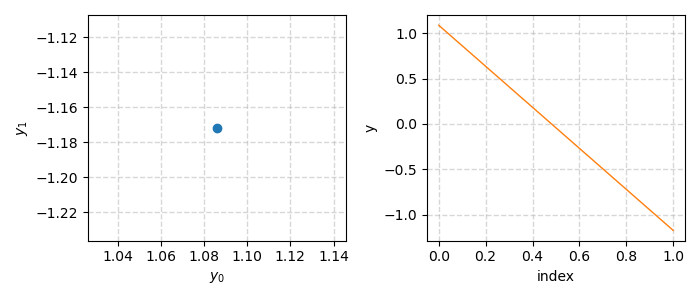

interactive(children=(FloatSlider(value=0.0, description='correlation', max=0.999, min=-0.999, step=0.001), In…

In [8]:
fig, (ay, ax) = mplt.subplots(1, 2, figsize=(7, 3))
ax.set_ylabel('y')
ax.set_xlabel('index')

line, = ay.plot([0], [0], 'o')
ay.set_ylabel(r'$y_1$')
ay.set_xlabel(r'$y_0$')

@ipywidgets.interact(correlation=(-0.999, 0.999, 0.001), n_samples=(1, 100, 1))
def plot_gauss(correlation=0, n_samples=1):
    [l.remove() for l in ax.lines]
    x = np.linspace(0, 1, 2)
    cov = np.eye(2)
    cov[0, 1] = correlation
    cov[1, 0] = correlation
    mean = np.zeros(x.size)
    data = np.random.multivariate_normal(mean, cov, size=n_samples)
    ax.plot(x, data.T, lw=1)
    ax.relim()
    ax.autoscale_view()
    line.set_data(data[:, 0], data[:, 1])
    ay.relim()
    ay.autoscale_view()
    fig.tight_layout()

When we go to higher dimensions it is difficult to visualize the variables the same way we did on the left, but the graph on the right can be readly applied for an arbitrary number of dimensions.

In the figure below we plot five samples of the $N$-dimensional vector of random variables as function of the coordinate index $i$. Note how the curves change as we increase the correlation between the several coordinates:

<IPython.core.display.Javascript object>


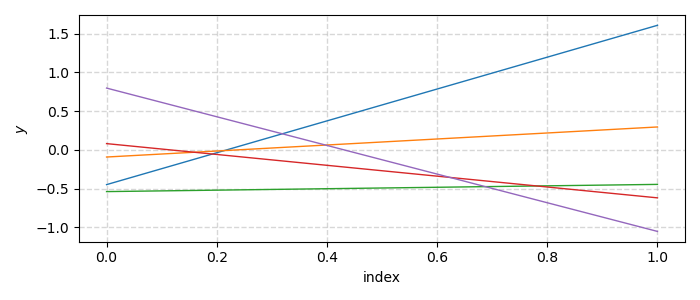

interactive(children=(FloatSlider(value=0.001, description='correlation', max=0.999, min=0.001, step=0.001), I…

In [4]:
fig, ax = mplt.subplots(1, 1, figsize=(7, 3))
ax.set_ylabel(r'$y$')
ax.set_xlabel('index')

@ipywidgets.interact(correlation=(1e-3, 0.999, 0.001), ndim=(2, 500, 1))
def plot_gauss(correlation=1e-3, ndim=2):
    ncurves=5
    [l.remove() for l in ax.lines]
    x = np.arange(ndim, dtype=float)/ndim
    cov = lib.KernelFuncs.squared_exponential(x, x, leng=correlation)
    mean = np.zeros(x.size)
    data = np.random.multivariate_normal(mean, cov, size=ncurves)
    ax.plot(data.T, lw=1)
    ax.relim()
    ax.autoscale_view()
    fig.tight_layout()

I was not completely honest in the graph above, because when we are in 2 dimensions there is only one way we can increase the correlation between the two variables. However when we go to higher dimensions, $N$, there are $N(N-1)/2$ free coefficients in the covariance matrix to define the covariance between each pair of coordinates. In the graph above I changed the covariance matrix in a very specific way:

$$\Sigma_{ij} = K(i, j) := \exp\left(-\frac12\left(\frac{i-j}{Nl}\right)^2\right)$$

where $K(i,j)$ is called kernel function and $l$ is the variable we change in the knob of the graphic.

Note that the self-correlation, or the variance of every varible, is $K(i, i)=\exp(0)=1$ and the correlation between variables decays as they are more apart in the index set.

If I used another kernel we would have a very different figure. For example, consider the following covariance matrix:

$$\Sigma_{ij} = K(i, j) := \exp\left(-\frac{|i-j|}{Nl}\right)$$

we get the following behavior:

<IPython.core.display.Javascript object>


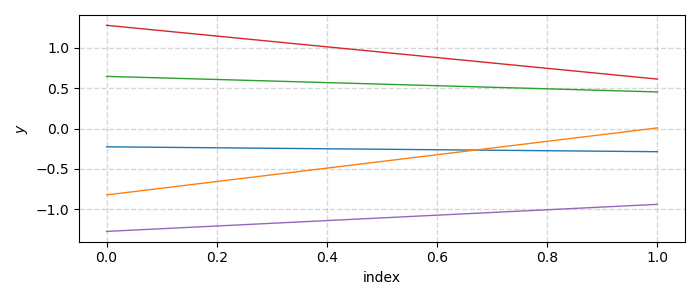

interactive(children=(FloatSlider(value=0.001, description='correlation', max=0.999, min=0.001, step=0.001), I…

In [5]:
fig, ax = mplt.subplots(1, 1, figsize=(7, 3))
ax.set_ylabel(r'$y$')
ax.set_xlabel('index')

@ipywidgets.interact(correlation=(1e-3, 0.999, 0.001), ndim=(2, 500, 1))
def plot_gauss(correlation=1e-3, ndim=2):
    ncurves=5
    [l.remove() for l in ax.lines]
    x = np.arange(ndim, dtype=float)/ndim
    cov = lib.KernelFuncs.exponential(x, x, leng=correlation)
    mean = np.zeros(x.size)
    data = np.random.multivariate_normal(mean, cov, size=ncurves)
    ax.plot(data.T, lw=1)
    ax.relim()
    ax.autoscale_view()
    fig.tight_layout()

which is continuous but not differentiable and is compatible with the brownian motion of a particle.

# Bayes Theorem and Bayesian Inference

Suppose we have a physical quantity $y$ whose value we don't know but we think it is distributed normally with $\sigma=3$. Since we don't know the value, we assume $\mu=0$. The PDF of this variable is given by:

$$P(y|\mu=0,\sigma=3) = \mathcal{N}(0,3) = \frac{1}{3\sqrt{2\pi}}\exp\left(-\frac12\frac{y^2}{3^2}\right)$$

In [2]:
# Code made by chatgpt with a few modifications

# Define the prior mean and standard deviation
mu_0 = 0
sigma_0 = 3

# Define a range of X values
X = np.linspace(-20, 20, 10000)

# Calculate the prior PDF
prior_pdf = scystat.norm.pdf(X, mu_0, sigma_0)

<IPython.core.display.Javascript object>


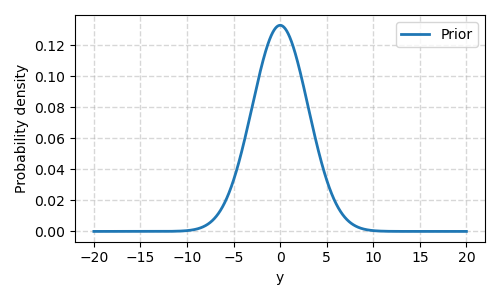

In [9]:
# Plot the prior PDF
fig, ax = mplt.subplots(1, 1, figsize=(5, 3))
ax.plot(X, prior_pdf, label='Prior')
ax.set_xlabel('y')
ax.set_ylabel('Probability density')
ax.legend(loc='best')
fig.tight_layout()
fig.show()

Now suppose we make a measurement $y_0$ of this quantity and the value is $5$. The measurement procedure has an uncertainty whose standard deviation is $1$. We could say that the result of the measurement also is a gaussian:

$$P(y_0|y, \mu_0=5, \sigma_0=1) = \mathcal{N}(5, 1) = \frac{1}{1\sqrt{2\pi}}\exp\left(-\frac12\frac{(y_0-5)^2}{1^2}\right)$$

we can use Bayes Theorem to update our beliefs given this new information:

$$P(y|y_0) = \frac{P(y_0|y)P(y)}{P(y_0)}$$

where :
 - $P(y|y_0)$ is called the posterior, because it represents our updated beliefs on $y$ after the measurement;
 - $P(y)=P(y|\mu,\sigma)$ is our prior assumption;
 - $P(y_0|y)$ called likelihood, which in our case is the measurement information;
 - $P(y_0)$ is the probability of having measured $y_0$ (marginal likelihood) which here we can consider just as a normalization constant

In [3]:
# Define the measurement mean and standard deviation
mu_x = [5, 1, 3, 2, 3.5]
sigma_x = [1, 4, 1.5, 2, 0.5]
frames = list(range(len(mu_x)))

<IPython.core.display.Javascript object>


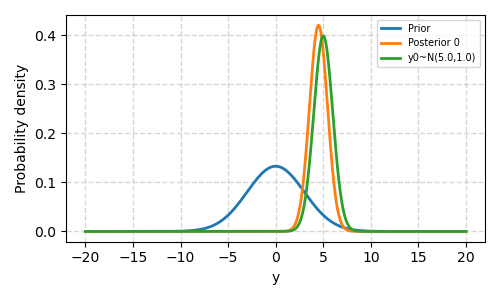

In [4]:
anim = lib.Animate.bayes(frames[:1], mu_x, sigma_x, X, prior_pdf)

If more data is measured our beliefs can be updated considering the previous posterior distribution as prior:

$$P(y|\{y_0,y_1\}) = \frac{P(y_1|y)P(y|y_0)}{P(y_1)} = \frac{P(y_1|y)P(y_0|y)P(y)}{P(y_1)P(y_0)}$$

This process can be repeated indefinetly considering new measurements are made:

$$P(y|\mathcal{D}) = \frac{\prod_\mathcal{D}P(y_i|y)}{\prod_\mathcal{D}P(y_i)}P(y), \quad \mathcal{D}=\{y_i| i=0..N\} \quad\mathrm{and}\quad y_i \sim \mathcal{N}(\mu_i, \sigma_i)$$

<IPython.core.display.Javascript object>


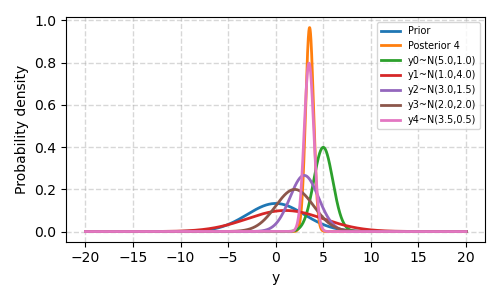

In [5]:
anim = lib.Animate.bayes(frames, mu_x, sigma_x, X, prior_pdf)

It is worth noticing that the final posterior does not depend on the order of the new data:

<IPython.core.display.Javascript object>


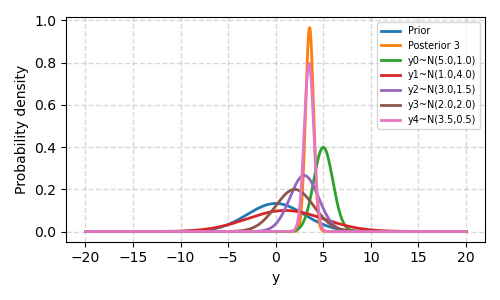

In [6]:
anim2 = lib.Animate.bayes(
    np.random.permutation(frames), mu_x, sigma_x, X, prior_pdf)

# Parametric Regression

As an example let's see how we could use the framework defined above to perform parametric regression of some curves.

First, let's start with the simple straight line model:

$$ f(x) = \omega_1 + \omega_2x = \vect{\phi}(x)^T\vect{\omega}$$

where $\vect{\omega} \in \mathbb{R}^2$ is the vector of random variables we want to know more about and $\vect{\phi}(x) = (1, x)^T$. When we look this way we see that the function is a random variable defined by the affine transformation $\vect{\phi}(x)$ of $\vect{\omega}$.

Now lets assume a gaussian prior on $\vect{\omega}$:

$$ \vect{\omega} \sim \mathcal{N}\left(\vect{\bar{\omega}}, \vect{\Sigma}\right)$$

Considering that f is just a linear combination of $\vect{\omega}$, the prior on $f(x)$ is given by:

$$ f(x) \sim \mathcal{N}\left(\vect{\phi}^T\vect{\bar{\omega}},\,\, \vect{\phi}^T\vect{\Sigma}\vect{\phi}\right)$$

The figure below shows the general behavior of this prior:

In [7]:
# Made up data
w_truth = (1, 2)
feat_func_truth = _partial(
    lib.FeatureFuncs.polynomial, num_features=len(w_truth))
num_data = 10
sigma_err = 1
x_data = (np.random.rand(num_data)-0.5)*2 * 6
y_data = feat_func_truth(x_data) @ w_truth
y_data += np.random.randn(*x_data.shape)*sigma_err

# points for inference and truth values:
num_pts = 100
x = np.linspace(-6, 6, num_pts)
truth = (x, feat_func_truth(x)@w_truth)

In [8]:
# Prior on omega
feat_func = lib.FeatureFuncs.linear
mu_prior = np.zeros(feat_func(np.zeros(1)).shape[1])
sigma_prior = 3*np.eye(mu_prior.size)
prior = scystat.multivariate_normal(mu_prior, sigma_prior)

<IPython.core.display.Javascript object>


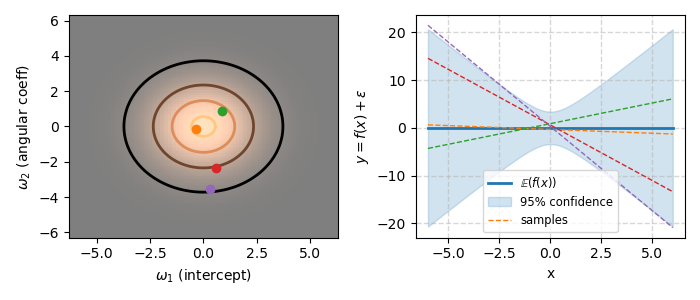

In [9]:
anim = lib.Animate.parametric_distribution(x, prior, feature_func=feat_func)

In [10]:
anim.repeat=False
# anim.resume()

Now, suppose that a total of $N$ measurements are performed, such that:

$$\mathcal{D} = \{(x_i, y_i)| i\in[1,N]\} = (\vect{x}, \vect{y})$$

where $y_i$ represent noisy observations of the underlying function $f(x_i)$:

$$y_i = f(x_i) + \varepsilon, \quad\mathrm{with}\quad \varepsilon \sim \mathcal{N}(0,\sigma^2)$$

This way we se that the likelyhood of all the measurements is given by:

$$P(\vect{y}|\vect{\omega}, \mathcal{D}) = \prod_\mathcal{D}\frac{1}{\sqrt{2\pi}\sigma}\exp\left(-\frac{(y_i-\vect{\phi}(x_i)^T\vect{\omega})^2}{2\sigma^2}\right)$$

Since we are considering all measurement error distributions are equally distributed (same $\sigma^2$) and gaussian. We can simplify the equation above such that:

$$P(\vect{y}|\vect{\omega}, \mathcal{D}) = \frac{1}{(2\pi)^{N/2}\sigma^N}\exp\left(-\frac{|\vect{y}-\vect{\Phi}^T\vect{\omega}|^2}{2\sigma^2}\right)$$

where we introduced the matrix $\vect{\Phi} := (\phi(x_1),...\phi(x_i),...\phi(x_N))$.

The posterior distribution can then be updated using Bayes theorem:

$$P(\vect{\omega}|\mathcal{D}) = \frac{P(\vect{y}|\vect{x},\vect{\omega})P(\vect{\omega})}{P(\vect{y}|\vect{x})} \propto
\exp\left(-\frac{1}{2\sigma^2}\left(\vect{y}-\vect{\Phi}^T\vect{\omega}\right)^T\left(\vect{y}-\vect{\Phi}^T\vect{\omega}\right)\right)
\exp\left(-\frac12(\vect{\omega}-\vect{\bar{\omega}})^T\vect{\Sigma}^{-1}(\vect{\omega}-\vect{\bar{\omega}})\right)
$$

Since all distributions are gaussian, we can analytically compute the posterior by completing the squares on the equation above. After some math we see the posterior is also gaussian:

$$P(\vect{\omega}|\mathcal{D}) = \mathcal{N}(\vect{\bar{\omega}_p}, \vect{\Sigma_p}),
\quad \mathrm{with} \quad
\vect{\bar{\omega}_p}=
\vect{\bar{\omega}} + \frac{1}{\sigma^2}\vect{\Sigma_p}\vect{\Phi}(\vect{y}-\vect{\Phi}^T\vect{\bar{\omega}})
\quad \mathrm{and} \quad
\vect{\Sigma_p}=\left(\sigma^{-2}\vect{\Phi}\vect{\Phi}^T + \vect{\Sigma}^{-1}\right)^{-1}$$

and, consequently, the posterior on $f(x)$ is also gaussian:

$$ f(x) \sim \mathcal{N}\left(\vect{\phi}^T\vect{\bar{\omega}_p},\,\, \vect{\phi}^T\vect{\Sigma_p}\vect{\phi}\right)$$

The animation below shows the process of the regression as data is measured, point by point, and how the posteriors are updated:

<IPython.core.display.Javascript object>


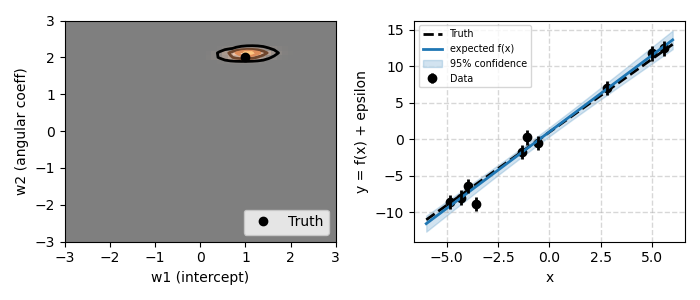

In [11]:
anim = lib.Animate.parametric_regression(
    x, x_data, y_data, prior, feat_func, sigma_err, truth=w_truth)

In [12]:
anim.repeat = False
# anim.resume()

The animation below shows the posterior distribution and some of its samples:

<IPython.core.display.Javascript object>


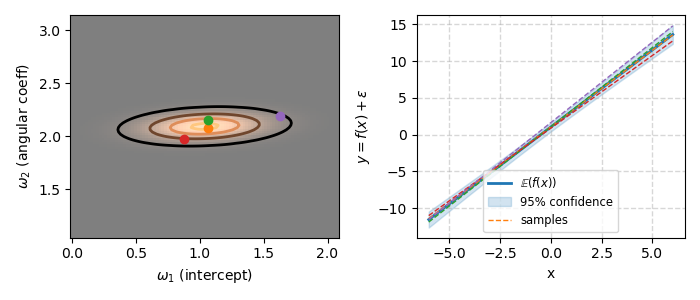

In [14]:
post = lib.Regressions.parametric_bayesian(
    x, x_data, y_data, prior, feat_func, sigma_err)
anim = lib.animate_distribution(x, post, feat_func)

In [15]:
anim.repeat = False
# anim.resume()

In [32]:
# Made up data
num_data = 10
sigma_err = 20
x_data = np.linspace(-5.5, 5.5, num_data)
x_data += np.random.randn(num_data)*0.2
x_data[x_data<-6] = -5.9
x_data[x_data>+6] = +5.9
x_data = np.random.permutation(x_data)
X = np.vstack([x_data, 2*np.ones(num_data)])
# y_data = np.log(lib.TestFunctions.rosenbrock(X))
y_data = lib.TestFunctions.himmelblau(X/1.2)
y_data += np.random.randn(*x_data.shape)*sigma_err

# points for inference and truth values:
num_pts = 100
x = np.linspace(-6, 6, num_pts)
X = np.vstack([x, 2*np.ones(num_pts)])
# fx = np.log(lib.TestFunctions.rosenbrock(X))
fx = lib.TestFunctions.himmelblau(X/1.2)
cov_amp = np.abs(fx).max()**2
truth = (x, fx)

In [5]:
# fig, ax = mplt.subplots(1, 1, figsize=(7, 4))

# ax.plot(x, lib.TestFunctions.styblinski(X/1.5), label='styblinski')
# ax.plot(x, lib.TestFunctions.rosenbrock(X/8), label='rosenbrock')
# ax.plot(x, lib.TestFunctions.beale(X), label='beale')
# ax.plot(x, lib.TestFunctions.himmelblau(X/1.2), label='himmelblau')
# ax.plot(x, lib.TestFunctions.eggholder(X*10), label='eggholder')
# ax.legend(loc='best')
# fig.tight_layout()
# fig.show()

In [30]:
# Prior on omega
feat_func = _partial(lib.FeatureFuncs.polynomial, num_features=5)
mu_prior = np.zeros(feat_func(np.zeros(1)).shape[1])
sigma_prior = cov_amp*np.eye(mu_prior.size)
prior = scystat.multivariate_normal(mu_prior, sigma_prior)

Notice that the formalism defined above can readly be applied to any model whose basis functions are fixed. For example, in the case of a polynomial we have:

$$f(x) = \omega_0 + \omega_1x + ... + \omega_px^p = \vect{\phi}^T\vect{\omega}$$

where now $\vect{\omega}, \vect{\phi} \in \mathbb{R}^p$ with $\phi = (1, x, ..., x^p)$ and the same equations above hold.

So that we have the prior on $\vect{\omega}$ being a $p$-dimensional multivariate gaussian:

<IPython.core.display.Javascript object>


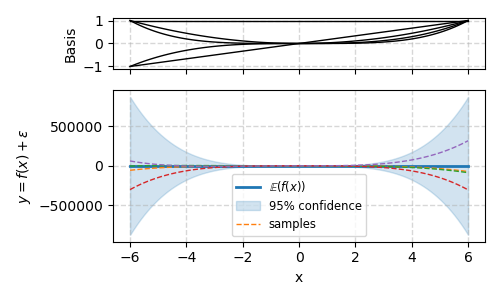

In [6]:
anim = lib.Animate.parametric_distribution(x, prior, feat_func)

In [7]:
anim.repeat=False
# anim.resume()

The regression evolution as new data comes in is shown below:

<IPython.core.display.Javascript object>


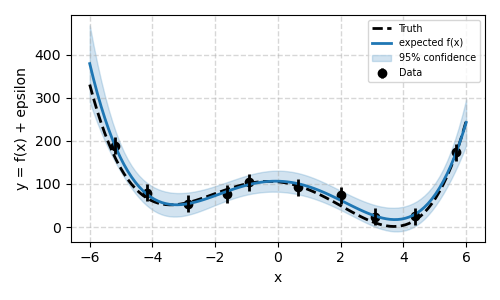

In [33]:
anim = lib.Animate.parametric_regression(
    x, x_data, y_data, prior, feat_func, sigma_err, truth=truth)

In [34]:
anim.repeat = False
# anim.resume()

In [35]:
# Prior on omega
feat_func = _partial(lib.FeatureFuncs.sines, num_freqs=6, L=6)
mu_prior = np.zeros(feat_func(np.zeros(1)).shape[1])
sigma_prior = cov_amp*np.eye(mu_prior.size)
prior = scystat.multivariate_normal(mu_prior, sigma_prior)

The same idea also applies when the basis functions are not polynomials. For example, in case they are sines and cossines:

$$\vect{\phi} = \left(1,
    \sin\left(\frac{2\pi x}{L}\right), ..., \sin\left(\frac{2\pi px}{L}\right),
    \cos\left(\frac{2\pi x}{L}\right), ..., \cos\left(\frac{2\pi px}{L}\right)\right)^T$$

where $L\in\mathbb{R}$ is a constant.

We have the following prior:

<IPython.core.display.Javascript object>


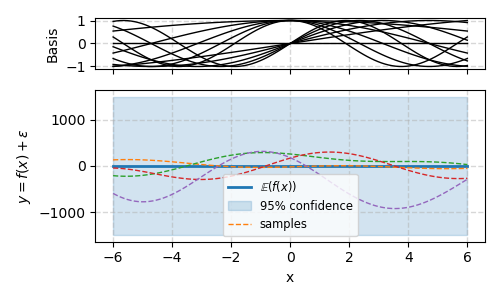

In [11]:
anim = lib.Animate.parametric_distribution(x, prior, feat_func)

In [12]:
anim.repeat=False
# anim.resume()

The regression process is shown below:

<IPython.core.display.Javascript object>


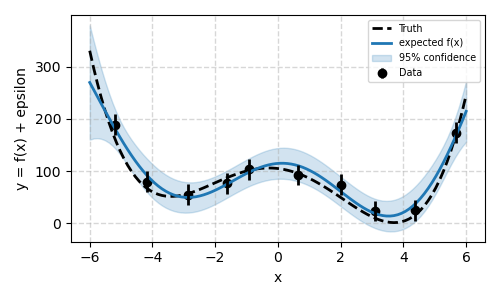

In [36]:
anim = lib.Animate.parametric_regression(
    x, x_data, y_data, prior, feat_func, sigma_err, truth=truth)

In [37]:
anim.repeat = False
# anim.resume()

In [38]:
# Prior on omega
feat_func = _partial(lib.FeatureFuncs.steps, step_range=6)
mu_prior = np.zeros(feat_func(np.zeros(1)).shape[1])
sigma_prior = cov_amp*np.eye(mu_prior.size)
prior = scystat.multivariate_normal(mu_prior, sigma_prior)

Discontinue functions are also an option. For example, in case they step functions:

$$\vect{\phi} = (\Theta(x-a_0),..., \Theta(x-a_p))^T, \,\, \mathrm{with}\,\,
\Theta(x) = \left\{\begin{matrix}-1 & x<0 \\ 0 & x = 0 \\ 1 & x>0\end{matrix}\right.$$

where $a_i\in\mathbb{R}$ for $i\in[0,p]\}$ are constants.

We have the following prior:

<IPython.core.display.Javascript object>


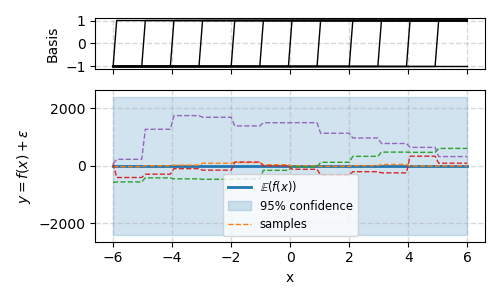

In [16]:
anim = lib.Animate.parametric_distribution(x, prior, feat_func)

In [17]:
anim.repeat=False
# anim.resume()

And the regression looks like:

<IPython.core.display.Javascript object>


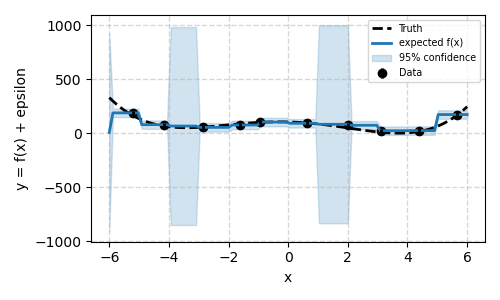

In [39]:
anim = lib.Animate.parametric_regression(
    x, x_data, y_data, prior, feat_func, sigma_err, truth=truth)

In [40]:
anim.repeat = False
# anim.resume()

In [41]:
# Prior on omega
feat_func = _partial(lib.FeatureFuncs.gauss, mean_range=6, sigma=2)
mu_prior = np.zeros(feat_func(np.zeros(1)).shape[1])
sigma_prior = cov_amp*np.eye(mu_prior.size)
prior = scystat.multivariate_normal(mu_prior, sigma_prior)

An interesting particular case of this formalism comes when the basis functions are equally spaced gaussian functions with the same variance:

$$\vect{\phi} = (
\exp\left(-\frac{(x-a_0)^2}{2\sigma}\right),
...,
\exp\left(-\frac{(x-a_p)^2}{2\sigma}\right),$$

where $\sigma\in\mathbb{R}$ and $a_i\in\mathbb{R}$ for $i\in[0,p]$ are both constants

Note from the prior how the samples are very smooth functions:

<IPython.core.display.Javascript object>


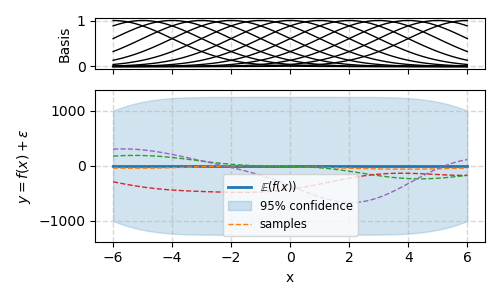

In [25]:
anim = lib.Animate.parametric_distribution(x, prior, feat_func)

In [26]:
anim.repeat=False
# anim.resume()

Another interesting feature of this set of basis functions is that the posterior tends towards the prior away from the data, since all basis functions go to zero at $\pm\infty$:

<IPython.core.display.Javascript object>


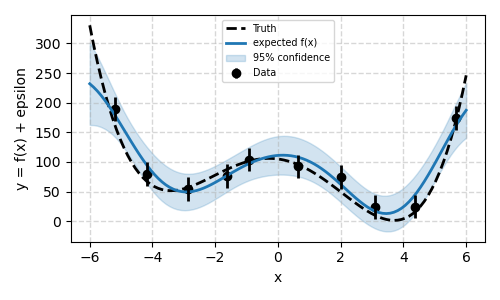

In [42]:
anim = lib.Animate.parametric_regression(
    x, x_data, y_data, prior, feat_func, sigma_err, truth=truth)

In [43]:
anim.repeat = False
# anim.resume()

To end this section on parametric fitting it is worth writting the posterior on $f(x)$ in a different manner. First recall that the posterior on $f(x)$ is given by:

$$ f(x_*) \sim \mathcal{N}\left(\vect{\phi_*}^T\vect{\bar{\omega}_p},\,\, \vect{\phi_*}^T\vect{\Sigma_p}\vect{\phi_*}\right)
\quad \mathrm{with} \quad
\vect{\bar{\omega}_p}=\vect{\bar{\omega}} + \frac{1}{\sigma^2}\vect{\Sigma_p}\vect{\Phi}\vect{y}
\quad \mathrm{and} \quad
\vect{\Sigma_p}=\left(\sigma^{-2}\vect{\Phi}\vect{\Phi}^T + \vect{\Sigma}^{-1}\right)^{-1}$$

where we introduced $x_*$ to denote the coordinate where we want to predict $f(x)$ and $\vect{\phi_*}=\vect{\phi}(x_*)$
Using an matrix identity, we can rewrite 

$$
\vect{\phi_*}^T\vect{\bar{\omega}_p} = 
\vect{\phi_*}^T\vect{\bar{\omega}} + \frac{1}{\sigma^2}\vect{\phi_*}^T\vect{\Sigma_p}\vect{\Phi}(\vect{y}-\vect{\Phi}^T\vect{\bar{\omega}}) =
\bar{f}(x_*) + K(x_*, \vect{x})\left(K(\vect{x}, \vect{x}) + \sigma^2\vect{I}\right)^{-1}(\vect{y}-\bar{f}(\vect{x}))$$
$$
\vect{\phi_*}^T\vect{\Sigma_p}\vect{\phi_*} =
\vect{\phi_*}^T\left(\sigma^{-2}\vect{\Phi}\vect{\Phi}^T + \vect{\Sigma}^{-1}\right)^{-1}\vect{\phi_*} =
K(x_*, x_*) - K(x_*,\vect{x})\left(K(\vect{x}, \vect{x}) + \sigma^2\vect{I}\right)^{-1}K(x_*,\vect{x})^T
$$ 

where we introduced the prior mean of $f(x)$ calculated at $x_*$ as $\bar{f}(x_*) = \vect{\phi_*}^T\vect{\bar{\omega}}$ and the kernel function $K(x_i, x_j) = \vect{\phi(x_i)}^T\vect{\Sigma}\vect{\phi}(x_j)$, that calculates the correlation between different points $x_i$ and $x_j$.

To summarize, the posterior becomes:

$$f(x_*) \sim \mathcal{N}\left(
\bar{f}(x_*) + K(x_*, \vect{x})\left(K(\vect{x}, \vect{x}) + \sigma^2\vect{I}\right)^{-1}(\vect{y}-\bar{f}(\vect{x})),\,\, 
K(x_*, x_*) - K(x_*,\vect{x})\left(K(\vect{x}, \vect{x}) + \sigma^2\vect{I}\right)^{-1}K(x_*,\vect{x})^T
\right)$$


Note that written in this form, the posterior on $f(x)$ does not depend explicitly on how we parametized $f(x)$ in the first place. It only depends on how the the points where the inference is to be made, $x_*$ are correlated to themselves and to the data points, $\vect{x}$, via the kernel function $K$.

This fact gives us a hint on how to perform a non-parametric regression, being the core idea behing gaussian processes.

We will see in the next section that all examples of parametric fitting shown here in the limit of an infinite number of basis functions for special cases of a gaussian process with different kernel functions.

# Gaussian Processes

With all the arguments presented above the definition of a gaussian process is very natural.

We say that a function 

$$f(\vect{x}): \mathbb{R}^N \rightarrow \mathbb{R}$$

is described by a gaussian process:

$$f(\vect{x}) \sim \mathcal{GP}(m(\vect{x}), K(\vect{x}, \vect{x'}))$$

where 

$$m(\vect{x}): \mathbb{R}^N \rightarrow \mathbb{R}$$

$$K(\vect{x}, \vect{x'}):\mathbb{R}^N\times\mathbb{R}^N \rightarrow \mathbb{R}$$

are the prior mean function and the covariance function (kernel), if for any finite set 

$$\mathcal{D}=\{(\vect{x_i}, f(\vect{x_i})) | \,\, i\in[1,p]\} = (\vect{X}, \vect{f}(\vect{X}))$$

the values of $f(\vect{x_i})$ are distributed according to a multivariate gaussian distribution:

$$\vect{f}(\vect{X})\sim\mathcal{N}(\vect{m}(\vect{X}), \vect{K}(\vect{X}, \vect{X}))).$$

In the equations above we introduced the notations:

$$\vect{X}=(\vect{x_1},..., \vect{x_p}) \in \mathbb{R}^N\times\mathbb{R}^p$$

$$\vect{f}(\vect{X})=(f(\vect{x_1}),..., f(\vect{x_p}))^T \in \mathbb{R}^p$$

$$\vect{m}(\vect{X})=(m(\vect{x_1}),..., m(\vect{x_p}))^T \in \mathbb{R}^p$$

$$\vect{K}(\vect{X}, \vect{X})= 
\begin{pmatrix}
K(\vect{x_1}, \vect{x_1}) & \cdot & K(\vect{x_1}, \vect{x_p})\\
\vdots & \ddots & \vdots\\
K(\vect{x_p}, \vect{x_1}) & \cdot & K(\vect{x_p}, \vect{x_p})\\
\end{pmatrix}\in \mathbb{R}^p\times\mathbb{R}^p$$

to make them compatible with a matrix notation.

The covariance function is a type of kernel that creates positive-semidefinite matrices. This means that:

$$\begin{pmatrix}\vect{x_1}^T & \cdots & \vect{x_p}^T\end{pmatrix}
\begin{pmatrix} K_{11} & \cdots & K_{1p}\\\vdots &\ddots&\vdots\\ K_{p1} &\cdots& K_{pp}\end{pmatrix}
\begin{pmatrix} \vect{x_1} \\ \vect{x_2} \end{pmatrix} = 
\sum_{i,j}^N K_{ij}\vect{x_i}^T\vect{x_j}(2-\delta_{ij})
\ge 0\,\, \forall \,\,\vect{x_1}, \vect{x_2} \in \mathbb{R}^N$$

Note that the behavior of the gaussian process is very dependent on the choice of the covariance function.

To make this influence more clear, let's check some widely used examples of covariance functions:

## Squared Exponential

This covariance functions 

<IPython.core.display.Javascript object>


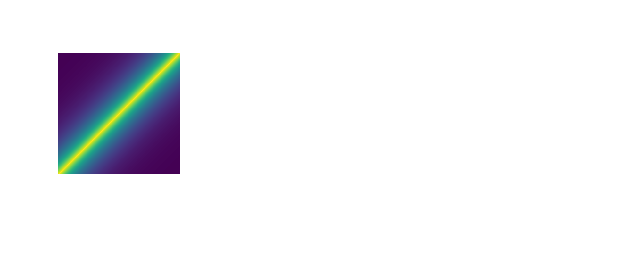

In [14]:
x = np.linspace(-6, 6, 500)
muf = np.zeros(x.shape)
cov = lib.KernelFuncs.exponential(x, x, leng=2, sigma=1)
dist = scystat.multivariate_normal(muf, cov)
anim = lib.Animate.gp_distribution(x, dist)

In [5]:
anim.repeat = False

<IPython.core.display.Javascript object>


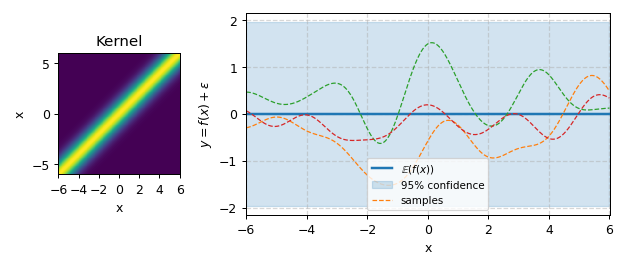

In [6]:
x = np.linspace(-6, 6, 500)
muf = np.zeros(x.shape)
cov = lib.KernelFuncs.squared_exponential(x, x, leng=1, sigma=1)
dist = scystat.multivariate_normal(muf, cov, allow_singular=True)
anim = lib.Animate.gp_distribution(x, dist)

In [7]:
anim.repeat = False

<IPython.core.display.Javascript object>


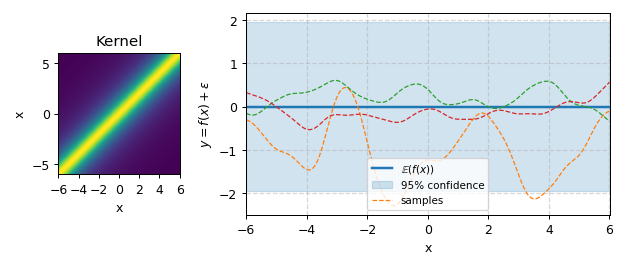

In [8]:
x = np.linspace(-6, 6, 500)
muf = np.zeros(x.shape)
cov = lib.KernelFuncs.rational_quadratic(x, x, leng=1, sigma=1)
dist = scystat.multivariate_normal(muf, cov, allow_singular=True)
anim = lib.Animate.gp_distribution(x, dist)

In [9]:
anim.repeat = False

<IPython.core.display.Javascript object>


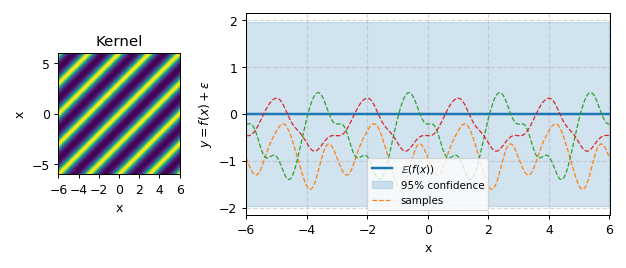

In [11]:
x = np.linspace(-6, 6, 500)
muf = np.zeros(x.shape)
cov = lib.KernelFuncs.sine_squared(x, x, leng=1, sigma=1, period=3)
dist = scystat.multivariate_normal(muf, cov, allow_singular=True)
anim = lib.Animate.gp_distribution(x, dist)

In [12]:
anim.repeat = False

Not only the type of the covariance function, but also the value of its parameters changes the look of the sample functions of the prior, as can be seen in the example below.

<IPython.core.display.Javascript object>


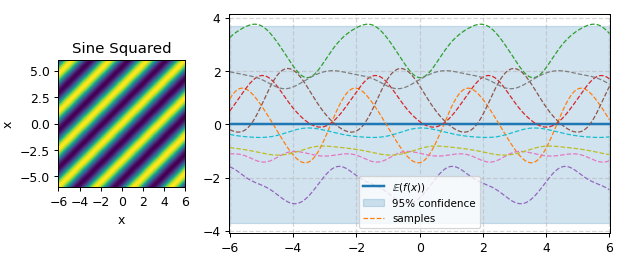

In [13]:
x = np.linspace(-6, 6, 500)
muf = np.zeros(x.shape)
x_, y_ = np.meshgrid(x, x)

fig, (ax, ay) = mplt.subplots(
    1, 2, figsize=(7, 3), sharex=True, width_ratios=[1, 3])

ax.set_ylabel('x')
ax.set_xlabel('x')
ax.set_aspect('equal')
ay.set_xlabel('x')
ay.set_ylabel(r'$y = f(x) + \varepsilon$')

def plot_gp(kernel='Exp Squared', leng=1, sigma=1, period=1):
    if kernel == 'Exp Squared':
        kern_func = lib.KernelFuncs.squared_exponential
    elif kernel == 'Exponential':
        kern_func = lib.KernelFuncs.exponential
    elif kernel == 'Matérn 3/2':
        kern_func = lib.KernelFuncs.matern3over2
    elif kernel == 'Matérn 5/2':
        kern_func = lib.KernelFuncs.matern5over2
    elif kernel == 'Rational Quad':
        kern_func = lib.KernelFuncs.rational_quadratic
    elif kernel == 'Sine Squared':
        kern_func = _partial(lib.KernelFuncs.sine_squared, period=period)
        
    cov = kern_func(x, x, leng=leng, sigma=sigma)
    dist = scystat.multivariate_normal(muf, cov, allow_singular=True)
    stdf = np.sqrt(np.diag(cov))

    # Create rotating samples from the distribution:
    # First define the levels we want:
    lev_smpl = -2*np.log(np.logspace(-6, 0, 10)*0.995)
    # Create normalized random vectors for rotation:
    N = muf.size
    nvec = lev_smpl.size
    v = np.random.randn(N, nvec)
    v /= np.linalg.norm(v, axis=0)
    v *= lev_smpl[None, :]

    # Create transformation matrix from v
    chol_cov = np.linalg.cholesky(cov + 1e-10*np.eye(cov.shape[0]))
    v = muf[:, None] + chol_cov @ v

    ax.pcolormesh(x_, y_, cov)
    ax.set_title(kernel)

    ay.clear()

    ay.plot(x, muf, label=r'$\mathbb{E}(f(x))$')
    ay.fill_between(
        x, muf+1.96*stdf, muf-1.96*stdf, color='C0', alpha=0.2,
        label='95% confidence')
    lines = [
        ay.plot(
            x, xd, '--', color=f'C{i:d}', lw=1)[0]
        for i, xd in enumerate(v.T, 1)]
    lines[0].set_label('samples')

    ay.legend(
        loc='lower center', bbox_to_anchor=(0.5, 0), fontsize='small')
    fig.tight_layout()

kerns = [
    'Exp Squared', 'Exponential', 'Matérn 3/2', 'Matérn 5/2', 'Rational Quad',
    'Sine Squared', ]
wid = ipywidgets.interactive(
    plot_gp,
    kernel=kerns, leng=(0.001, 4, 0.01), sigma=(0.001, 10, 0.01),
    period=(0.001, 10, 0.01))

controls = ipywidgets.HBox(
    wid.children[:-1],
    layout=ipywidgets.Layout(flex_flow='row wrap'))
output = wid.children[-1]
display(ipywidgets.VBox([controls, output]))

The idea is that the Gaussian Process describes a prior, which can be updated when new data is measured via Bayes Theorem. Let's check how this works below: suppose we perform $m$ noisy measurements of $f(\vect{x})$ at locations

$$\vect{X} = (\vect{x_1}, \cdots, \vect{x_m}),$$

and want to know the posterior of $f(x)$ at another $p$ points

$$\vect{X_*} = (\vect{x_{m+1}}, \cdots, \vect{x_{m+p}}),$$

The prior joint distribution of $\vect{f}(\vect{X})$ and $\vect{f}(\vect{X_*})$ is given by:

$$\begin{pmatrix}\vect{f} \\ \vect{f_*} \end{pmatrix} \sim \mathcal{N}\left(
\begin{pmatrix}\vect{m} \\ \vect{m_*}\end{pmatrix},\,\,
\begin{pmatrix}\vect{K} & \vect{K_*}^T \\ \vect{K_*} & \vect{K_{**}} \end{pmatrix}
\right)$$

where we introduced a short notation 
$$\vect{m}=\vect{m}(\vect{X}), \quad \vect{f}=\vect{m}(\vect{X}),$$ 

$$\vect{m_*}=\vect{m}(\vect{X_*}),\quad \vect{f_*}=\vect{m}(\vect{X_*}),$$ 

$$\vect{K}=\vect{K}(\vect{X}, \vect{X}), \quad \vect{K_*}=\vect{K}(\vect{X_*}, \vect{X})=\vect{K}(\vect{X}, \vect{X_*})^T,\,\, \mathrm{and} \quad \vect{K_{**}}=\vect{K}(\vect{X_*}, \vect{X_*}).$$

If we assume the noisy measurements $\vect{y}$ all have the same uncertainty $\varepsilon_i\sim\mathcal{N}(0, \sigma)$:

$$\vect{y} = \vect{f} + \vect{\varepsilon}, \quad \mathrm{with}\quad
\vect{\varepsilon}=(\varepsilon_1,\cdots, \varepsilon_m),$$

the joint distribution of $\vect{y}$ and $\vect{f_*}$ is given by:

$$\begin{pmatrix}\vect{y} \\ \vect{f_*} \end{pmatrix} \sim \mathcal{N}\left(
\begin{pmatrix}\vect{m} \\ \vect{m_*}\end{pmatrix},\,\,
\begin{pmatrix}\vect{K} + \sigma^2\vect{I} & \vect{K_*}^T \\ \vect{K_*} & \vect{K_{**}} \end{pmatrix}
\right).$$

This way, the posterior of $\vect{f_*}$ can be calculated simply by taking the conditional probability below:

$$P(\vect{f_*}|\vect{X}, \vect{y}, \vect{X^*}) = \mathcal{N}\left(
\vect{m_*} + \vect{K_*}(\vect{K}+\sigma^2\vect{I})^{-1})(\vect{y}- \vect{m}),\,\,
\vect{K_{**}} - \vect{K_*}(\vect{K}+\sigma^2\vect{I})^{-1})\vect{K_*}^T)
\right)$$

In [47]:
lib.KernelFuncs.squared_exponential(x, x_data).

(100, 10)

In [44]:
post = lib.Regressions.non_parametric(
    x, x_data, y_data, lib.KernelFuncs.squared_exponential, noise_var=sigma_err)

LinAlgError: When `allow_singular is False`, the input matrix must be symmetric positive definite.